## Adaptation of CI - A multi-level approach
In this example we demonstrate how adaptations of different levels (hazard-, asset-, network- and system-level) can be appraised based on their cost of adaptation, risk, and benefits of adaptation. This notebook covers the calculation of direct damage; subsequent notebooks cover indirect losses, and adaptation appraisal.

### Adaptation of CI - Direct damages
The calculation of direct damages is based on the DamageScanner by Koks, et al (2023) *(DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)*

Data of assets downloaded from OpenStreetMap (OSM) are overlayed with vectorised flood maps (BfG, 2019) and depth-damage functions (Kellerman, et al. 2015) are used to determine the damage to the railway. The direct risk is calculated by using the trapezoidal rule over the damages produced by 3 floods of different return periods. Future risk is calculated using results from the Transformed-Stationary methodology for non-stationary Extreme Value Analysis (Mentaschi et al., 2016). A sample of data is included in the data directory.

In this demonstration only the rail track is considered, though damage to other asset types can also be calculated using the correct depth-damage functions (see Nirandjan, et al. (2024)). 

In [1]:
import os
# os.chdir('path/to/book/directory')
# os.chdir('..')
from src import damagescanner_rail_track as ds
from src.ci_adapt_utilities import *
import matplotlib.pyplot as plt

data_path = Path(os.getcwd() + '/data')
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

Load default configuration and model parameters

In [ ]:
# Load configuration with ini file (created running config.py)
config_file = Path(os.getcwd() + '/config_ci_adapt_test.ini')
hazard_type, infra_type, _, country_name, _, _, vulnerability_data = load_config(config_file)

Read exposure (assets), vulnerability (depth-damage curves), and hazard data

In [ ]:
# Load asset data (OpenStreetMap contributors. (2023). Germany country dump retrieved from OSM. https://www.openstreetmap.org)
assets, geom_dict, _, _, _, rp_spec_priority, _, _, _ = startup_ci_adapt(data_path, config_file)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
type_dict = assets['asset'].to_dict()

675 assets loaded.


In [6]:
# Read vulnerability and maximum damage data (Nirandjan, S., Koks, E. E., Ye, M., Pant, R., Van Ginkel, K. C. H., Aerts, J. C. J. H., & Ward, P. J. (2024). Review article: Physical Vulnerability Database for Critical Infrastructure Multi-Hazard Risk Assessments – A systematic review and data collection. https://doi.org/10.5194/nhess-2023-208)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.1.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [7]:
# Read hazard data (BfG. (2019). BfG OpenData Dataset Überflutungstiefen (Hochwasserrisikomanagement-RL 2. Zyklus 2016-2021) [Dataset]. https://geoportal.bafg.de/download/opendata/ueberflutungstiefen-2019/servicefeed.xml)
test_haz_path = data_path / r'Floods\Germany\basin_intersections'
hazard_data_list = ds.read_hazard_data(test_haz_path, hazard_type, country=country_name, subfolders=None)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 9 hazard maps.


Overlay hazard and asset data

In [8]:
# Calculate direct damage by asset (Koks. E.E. (2023). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict, asset_options=asset_options, rp_spec_priority=rp_spec_priority)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2025-01-06 16:20:07 - Reading hazard map 1 of 9: flood_DERP_RW_H_4326_2080428500
2025-01-06 16:20:07 - Coarse overlay of hazard map with assets...
2025-01-06 16:20:10 - Reading hazard map 2 of 9: flood_DERP_RW_H_4326_2080430240
2025-01-06 16:20:11 - Coarse overlay of hazard map with assets...
2025-01-06 16:20:57 - Reading hazard map 3 of 9: flood_DERP_RW_H_4326_2080430320
2025-01-06 16:20:58 - Coarse overlay of hazard map with assets...
2025-01-06 16:21:56 - Reading hazard map 4 of 9: flood_DERP_RW_L_4326_2080428500
2025-01-06 16:21:56 - Coarse overlay of hazard map with assets...
2025-01-06 16:22:13 - Reading hazard map 5 of 9: flood_DERP_RW_L_4326_2080430240
2025-01-06 16:22:15 - Coarse overlay of hazard map with assets...
2025-01-06 16:23:36 - Reading hazard map 6 of 9: flood_DERP_RW_L_4326_2080430320
2025-01-06 16:23:39 - Coarse overlay of hazard map with assets...
2025-01-06 16:26:48 - Reading hazard map 7 of 9: flood_DERP_RW_M_4326_2080428500
2025-01-06 16:26:48 - Coarse overlay 

Save overlay data to files for reuse in later stages of the analysis

In [13]:
# Save the data to csv files
csv_output_path=f'collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / csv_output_path)

# Save the data to geojson files
dd_gdf=create_dd_gdf(assets, collect_output, rp_spec_priority, average = True)
# dd_gdf.to_file(f'{data_path}/output/impacts/direct_damages.geojson', driver='GeoJSON')
dd_gdf.to_parquet(f'{data_path}/output/impacts/direct_damages.pq')


Visualise direct damages and calculate risk

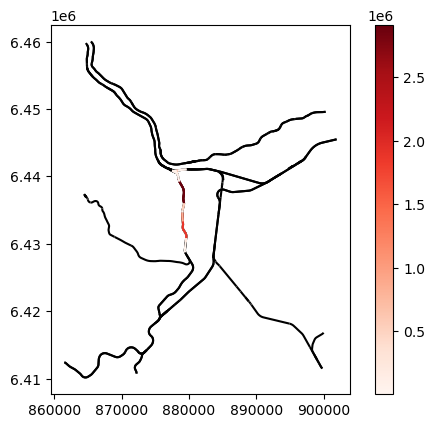

In [10]:
#plot the gdf and color each feature by the value of flood_DERP_RW_L_4326_2080430320_avg or black if no value
fig, ax = plt.subplots()
dd_gdf.plot(ax=ax, legend=False, color='black')
# If an average is produced, then hazard_map_avg is added as a column, else two columns _lower and _upper are added. Here average is used.
dd_gdf.plot(column='flood_DERP_RW_L_4326_2080430320_avg', ax=ax, legend=True, cmap='Reds')
plt.show()

In [14]:
# Sum the direct damages for each hazard map
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

In [15]:
# Calculate the risk as expected annual damages (EAD) by basin
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (eg "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
rps_derp = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. This value is catchment-specific. 
increase_factor = {
    '_H_': 2,
    '_M_': 4.21,
    '_L_': 5.86
} # Mentaschi et al. (2016)
num_years = 100

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = calculate_dynamic_return_periods(rps_derp, num_years, increase_factor) 

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

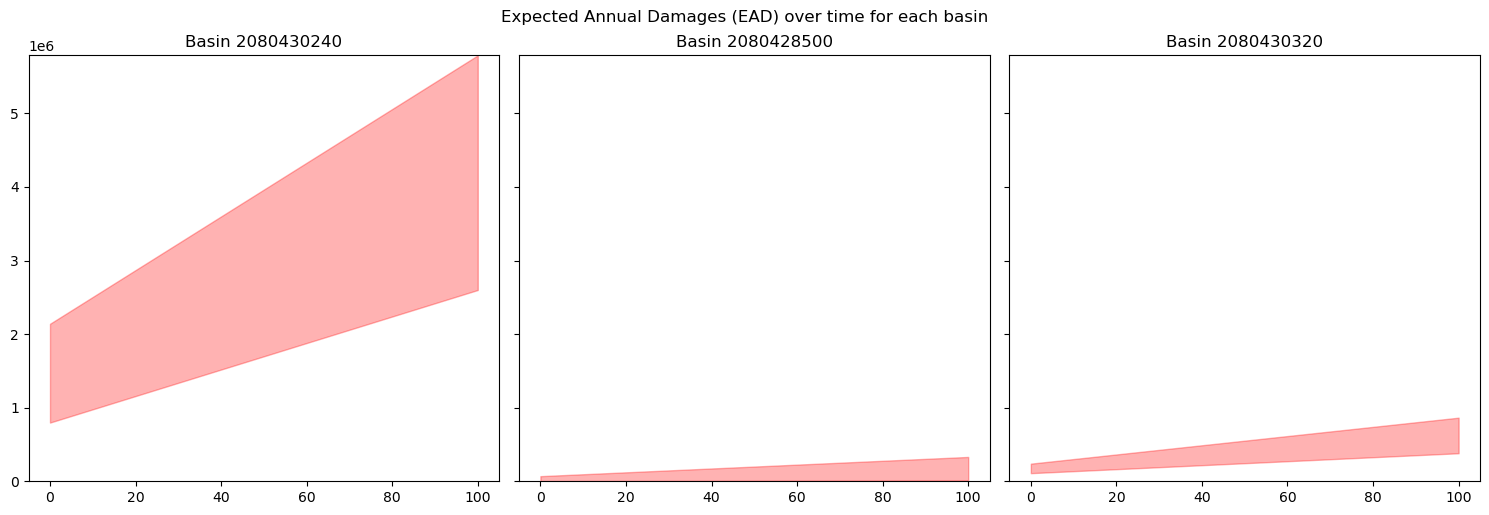

In [16]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = min(4, num_basins)
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
try:
    axs = axs.flatten()
except:
    axs = [axs]

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()


In [16]:
# with open(f'{interim_data_path}/ead_by_ts_by_basin_direct.pkl', 'wb') as f:
#     pickle.dump(ead_by_ts_by_basin, f)